# Musical Instruments Category - Business Questions Implementation

**Category**: Musical Instruments  

In [2]:
import os
from pathlib import Path
from datetime import datetime, timedelta
import warnings

import rootutils
rootutils.setup_root(Path.cwd(), indicator=".project-root", pythonpath=True)

ROOT_DIR = Path(os.environ.get("PROJECT_ROOT", Path.cwd()))
CLEANED_REVIEWS_PATH = ROOT_DIR / "data/cleaned/review_categories/musical_instruments_reviews_cleaned.parquet"
CLEANED_METADATA_PATH = ROOT_DIR / "data/cleaned/meta_categories/musical_instruments_metadata_cleaned.parquet"

warnings.filterwarnings("ignore")

In [3]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from src.amazon_reviews_analysis.utils import build_spark

# Initialize Spark
spark = build_spark()
print("✓ Spark Session created successfully!")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/12 12:44:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/12 12:44:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


✓ Spark Session created successfully!


In [4]:
print("📂 Loading cleaned datasets...")
reviews_df = spark.read.parquet(str(CLEANED_REVIEWS_PATH))
metadata_df = spark.read.parquet(str(CLEANED_METADATA_PATH))

print(f"Reviews: {reviews_df.count():,} records")
print(f"Metadata: {metadata_df.count():,} records")

📂 Loading cleaned datasets...
Reviews: 2,980,998 records
Metadata: 213,577 records


## Q1: Premium High-Rated Instruments (FILTER)

In [5]:
total_meta = metadata_df.count()
price_missing = metadata_df.filter(col("price").isNull()).count()
price_present = metadata_df.filter(col("price").isNotNull()).count()

print(f"\nPrice Statistics:")
print(f"  Total products: {total_meta:,}")
print(f"  With price: {price_present:,} ({price_present/total_meta*100:.1f}%)")
print(f"  Missing price: {price_missing:,} ({price_missing/total_meta*100:.1f}%)")


Price Statistics:
  Total products: 213,577
  With price: 84,909 (39.8%)
  Missing price: 128,668 (60.2%)


In [6]:
metadata_cleaned = metadata_df.filter(
    col("price").isNotNull() &
    col("average_rating").isNotNull() &
    col("rating_number").isNotNull()
)

In [11]:
from pyspark.sql.functions import col, regexp_replace, expr

# Clean and safely cast numeric columns
metadata_cleaned = metadata_df.select(
    col("*"),
    expr("try_cast(regexp_replace(price, '[$,]', '') AS double)").alias("price_num"),
    expr("try_cast(average_rating AS double)").alias("average_rating_num"),
    expr("try_cast(rating_number AS int)").alias("rating_number_num")
).filter(
    col("price_num").isNotNull() &
    col("average_rating_num").isNotNull() &
    col("rating_number_num").isNotNull()
)

# Apply your query filters safely
q1_result = metadata_cleaned.filter(
    (col("price_num") > 200) &
    (col("average_rating_num") >= 4.5) &
    (col("rating_number_num") >= 50)
).select(
    "parent_asin",
    "title",
    col("price_num").alias("price"),
    col("average_rating_num").alias("average_rating"),
    col("rating_number_num").alias("rating_number"),
    "store"
).orderBy(col("rating_number").desc())

# Display results
print(f"Found {q1_result.count()} premium high-rated instruments\n")
q1_result.show(10, truncate=50)


Found 1163 premium high-rated instruments

+-----------+--------------------------------------------------+------+--------------+-------------+-------------+
|parent_asin|                                             title| price|average_rating|rating_number|        store|
+-----------+--------------------------------------------------+------+--------------+-------------+-------------+
| B09RN7GR8F|Focusrite Scarlett 4i4 3rd Gen USB Audio Interf...|229.99|           4.7|        43271|    Focusrite|
| B07CYRYQ8G|                        Behringer U-PHORIA UMC1820| 299.0|           4.5|        20370|    Behringer|
| B09XBYX6YR|Alesis Recital – 88 Key Digital Piano Keyboard ...|254.98|           4.6|        11206|       Alesis|
| B0BXLY8HJG|Alesis Drums Nitro Mesh Kit - Electric Drum Set...|432.85|           4.6|         9620|       Alesis|
| B0B89ZSYS7|Shure SM7B Vocal Dynamic Microphone for Broadca...| 399.0|           4.9|         9512|        Shure|
| B09VBWXMBC|Positive Grid Spark Pear

Premium instruments with high ratings and substantial review counts are valuable for targeted marketing. These instruments represent well-established, trusted products in the music market.

## Q2: Recent Highly Helpful Reviews (FILTER)

In [12]:
print("Filter: helpful_vote ≥ 20 AND verified_purchase = True AND last 12 months\n")

# calculate timestamp for 12 months ago
twelve_months_ago = int((datetime.now() - timedelta(days=365)).timestamp())

q2_result = reviews_df.filter(
    (col("helpful_vote") >= 20) & 
    (col("verified_purchase") == True) &
    (col("timestamp") >= twelve_months_ago)
).withColumn("review_date", from_unixtime("timestamp")) \
.select(
    "asin",
    "title",
    "rating",
    "helpful_vote",
    "review_date",
    substring("text", 1, 100).alias("text_preview")
).orderBy(col("helpful_vote").desc())

print(f"Found {q2_result.count()} highly helpful recent reviews\n")
q2_result.show(10, truncate=60)

Filter: helpful_vote ≥ 20 AND verified_purchase = True AND last 12 months

Found 19091 highly helpful recent reviews



+----------+------------------------------------------------------------+------+------------+---------------------+------------------------------------------------------------+
|      asin|                                                       title|rating|helpful_vote|          review_date|                                                text_preview|
+----------+------------------------------------------------------------+------+------------+---------------------+------------------------------------------------------------+
|B07WLWN2ZT|                                    Great quality microphone|   5.0|        4650|+51794-08-09 18:33:36|[[VIDEOID:b0a0dd6a2f03434fa8fe8ff2b7ac3e9e]] I have uploa...|
|B01MXL3EOU|                                    Great mic for the price!|   5.0|        4234|+50055-01-02 11:40:08|[[VIDEOID:2133af750ebbe01652b74bf7b632243f]] Great mic fo...|
|B002VA464S|An incredible microphone packed full of features - for an...|   5.0|        3158|+44513-05-15 07:36:40|

Highly helpful reviews indicate community engagement and trust. For musical instruments, these reviews often contain technical details and performance insights valuable to potential buyers.

## Q3: Problem Instruments (FILTER)

In [13]:
print("Filter: average_rating < 3.0 AND reviews ≥ 30 AND last 12 months\n")

# get products with recent poor reviews
recent_reviews = reviews_df.filter(col("timestamp") >= twelve_months_ago)

problem_products = recent_reviews.groupBy("parent_asin") \
    .agg(
        avg("rating").alias("recent_avg_rating"),
        count("*").alias("recent_review_count")
    ) \
    .filter(
        (col("recent_avg_rating") < 3.0) & 
        (col("recent_review_count") >= 30)
    ) \
    .join(metadata_df.select("parent_asin", "title", "store", "average_rating"), "parent_asin") \
    .select(
        "parent_asin",
        "title",
        "store",
        col("average_rating").alias("overall_rating"),
        "recent_avg_rating",
        "recent_review_count"
    ).orderBy("recent_avg_rating")

print(f"Found {problem_products.count()} problem instruments\n")
problem_products.show(10, truncate=50)

Filter: average_rating < 3.0 AND reviews ≥ 30 AND last 12 months



Found 230 problem instruments



+-----------+--------------------------------------------------+-----------------+--------------+------------------+-------------------+
|parent_asin|                                             title|            store|overall_rating| recent_avg_rating|recent_review_count|
+-----------+--------------------------------------------------+-----------------+--------------+------------------+-------------------+
| B01KS9H230|EaseUS Data Recovery Wizard Pro 10.8 for PC - D...|           EaseUS|           1.8| 1.263157894736842|                 38|
| B09TB2P795|QNQA Shaman Drum, Tree of Life Decoration Desig...|             QNQA|           2.1|               1.5|                 72|
| B08LGD9XD7|2 Pack Pocket Staff, Retractable Collapsible Bo...|         ROLLMOSS|           2.8| 1.726027397260274|                 73|
| B00DH9TBCE|                               EZ Pro DJ Turntable|        EZ Pro DJ|           2.7|1.7321428571428572|                 56|
| B0994QM35T|Gosono 2PCS Guitar Bass Stri

Problem instruments with quality or reliability issues need attention. This could indicate manufacturing defects, shipping damage, or other quality control issues critical for musical equipment.

## Q4: Price Range vs Customer Satisfaction (JOIN + GROUP BY)

In [17]:
from pyspark.sql.functions import col, when, expr, regexp_replace

# Remove any existing 'price_num' column before creating a new one
metadata_temp = metadata_cleaned.drop("price_num")

# Safely parse numeric price
metadata_with_ranges = metadata_temp.withColumn(
    "price_num",
    expr("try_cast(regexp_replace(price, '[$,]', '') AS double)")
).filter(col("price_num").isNotNull())

# Categorize price ranges
metadata_with_ranges = metadata_with_ranges.withColumn(
    "price_range",
    when(col("price_num") < 50, "Budget (<$50)")
    .when(col("price_num") < 200, "Mid ($50-200)")
    .when(col("price_num") < 500, "Premium ($200-500)")
    .otherwise("Luxury (>$500)")
)

# Show sample
metadata_with_ranges.select("parent_asin", "price", "price_num", "price_range").show(5)


+-----------+-----+---------+-------------+
|parent_asin|price|price_num|  price_range|
+-----------+-----+---------+-------------+
| 0014031655|31.99|    31.99|Budget (<$50)|
| 0711981272|14.99|    14.99|Budget (<$50)|
| 0739003666| 9.99|     9.99|Budget (<$50)|
| 073902213X|12.99|    12.99|Budget (<$50)|
| 0739048139|19.95|    19.95|Budget (<$50)|
+-----------+-----+---------+-------------+
only showing top 5 rows


In [18]:
metadata_compact = metadata_with_ranges.select("parent_asin", "price_range")

In [19]:
reviews_compact = reviews_df.select("parent_asin", "rating", "helpful_vote")

In [21]:
from pyspark.sql.functions import avg, countDistinct

q4_result = reviews_compact.join(
    metadata_with_ranges,
    "parent_asin",
    "inner"
).groupBy("price_range").agg(
    avg("rating").alias("avg_customer_rating"),
    countDistinct("parent_asin").alias("unique_products"),
    avg("helpful_vote").alias("avg_helpful_votes")
).orderBy("avg_customer_rating", ascending=False)

q4_result.show()


+------------------+-------------------+---------------+------------------+
|       price_range|avg_customer_rating|unique_products| avg_helpful_votes|
+------------------+-------------------+---------------+------------------+
|    Luxury (>$500)|  4.359970866715222|           4304|3.6078951201747995|
|     Budget (<$50)|  4.296266719612715|          50582|0.7553469182771901|
|     Mid ($50-200)| 4.2794781159295345|          21463|1.5106838712149515|
|Premium ($200-500)|  4.277644041485748|           8471|2.3640651833187096|
+------------------+-------------------+---------------+------------------+



In [22]:
q4_result.show(truncate=False)

+------------------+-------------------+---------------+------------------+
|price_range       |avg_customer_rating|unique_products|avg_helpful_votes |
+------------------+-------------------+---------------+------------------+
|Luxury (>$500)    |4.359970866715222  |4304           |3.6078951201747995|
|Budget (<$50)     |4.296266719612715  |50582          |0.7553469182771901|
|Mid ($50-200)     |4.2794781159295345 |21463          |1.5106838712149515|
|Premium ($200-500)|4.277644041485748  |8471           |2.3640651833187096|
+------------------+-------------------+---------------+------------------+



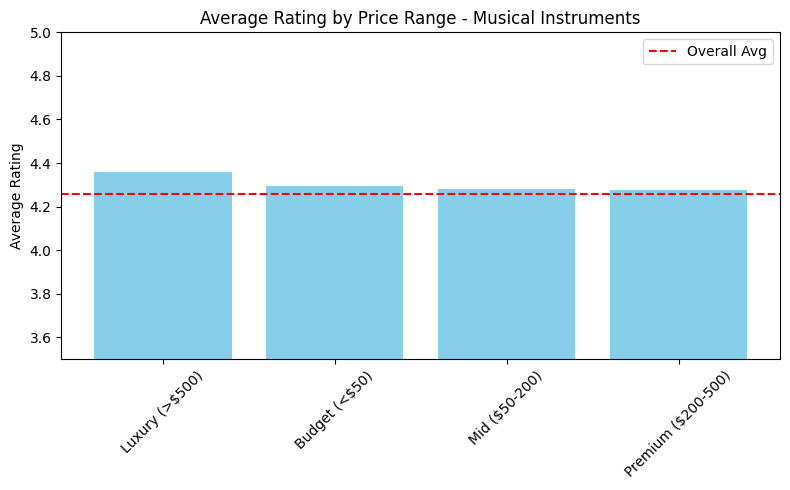

In [23]:
import matplotlib.pyplot as plt

q4_pdf = q4_result.toPandas()

plt.figure(figsize=(8, 5))

plt.bar(q4_pdf["price_range"], q4_pdf["avg_customer_rating"], color='skyblue')
plt.title("Average Rating by Price Range - Musical Instruments")
plt.ylabel("Average Rating")
plt.ylim(3.5, 5.0)

overall_avg = reviews_df.select(avg("rating")).collect()[0][0]
plt.axhline(y=overall_avg, color='red', linestyle='--', label='Overall Avg')

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

For musical instruments, price tier affects customer satisfaction differently than other categories. Premium and luxury segments show performance expectations and feedback patterns unique to the music instrument market.

## Q5: Top Reviewers vs Overall Average (JOIN)

In [24]:
print("Compare users with 20+ reviews vs overall average\n")

# calculate overall average
overall_avg = reviews_df.select(avg("rating")).collect()[0][0]
print(f"Overall category average rating: {overall_avg:.3f}\n")

# find power reviewers
power_reviewers = reviews_df.groupBy("user_id") \
    .agg(
        count("*").alias("review_count"),
        avg("rating").alias("avg_rating"),
        avg("helpful_vote").alias("avg_helpful"),
        countDistinct("parent_asin").alias("unique_products")
    ) \
    .filter(col("review_count") >= 20) \
    .withColumn("vs_overall", col("avg_rating") - overall_avg) \
    .orderBy(col("review_count").desc())

print(f"Found {power_reviewers.count()} power reviewers (20+ reviews)\n")

# show top 20
power_reviewers.show(20, truncate=False)

Compare users with 20+ reviews vs overall average

Overall category average rating: 4.256

Found 5399 power reviewers (20+ reviews)



+----------------------------+------------+------------------+------------------+---------------+--------------------+
|user_id                     |review_count|avg_rating        |avg_helpful       |unique_products|vs_overall          |
+----------------------------+------------+------------------+------------------+---------------+--------------------+
|AG3S4FROO422V5KP7DJCBXVUQLJQ|497         |4.804828973843058 |5.181086519114688 |478            |0.5483883455702445  |
|AEYOYD3W6NQ6DMG3F2L5E2JNAQPA|302         |4.751655629139073 |0.3211920529801324|291            |0.495215000866259   |
|AF7CC34DK36SQJS7WXI44DREGWJA|292         |4.530821917808219 |0.2808219178082192|287            |0.2743812895354054  |
|AH4GZFH3BWFUJTLJ7P4QEFSWGZYA|257         |4.35408560311284  |4.976653696498055 |248            |0.09764497484002632 |
|AHGDGGMCSMMALHTX6WGLJFFUVJXA|240         |4.466666666666667 |0.775             |234            |0.210226038393853   |
|AG5ZVXXHEXDYUUODSEQC4XXV7DPA|224         |4.763

Power reviewers in the musical instruments category are valued community members, often experienced musicians who provide detailed technical feedback.

## Q6: Monthly Rating Trends (GROUP BY)

In [25]:
print("\nSample timestamps from dataset:")
reviews_df.select("timestamp").show(10, truncate=False)


Sample timestamps from dataset:
+-------------+
|timestamp    |
+-------------+
|1507779520679|
|1507779023637|
|1655151533955|
|1610310313325|
|1410224547000|
|1669008013628|
|1600587368817|
|1601255016799|
|1435274226000|
|1639657663197|
+-------------+
only showing top 10 rows


In [26]:
print("\nChecking date range in dataset...")

date_range = reviews_df.select(
    from_unixtime(col("timestamp") / 1000).alias("date")
).agg(
    min("date").alias("oldest"),
    max("date").alias("newest")
).collect()[0]

print(f"  Oldest review: {date_range['oldest']}")
print(f"  Newest review: {date_range['newest']}")

newest_date = datetime.strptime(date_range['newest'][:19], "%Y-%m-%d %H:%M:%S")
two_years_ago = newest_date - timedelta(days=730)

print(f"\nAnalyzing period: {two_years_ago.date()} to {newest_date.date()}")


Checking date range in dataset...
  Oldest review: 1999-08-26 05:51:32
  Newest review: 2023-09-12 22:25:04

Analyzing period: 2021-09-12 to 2023-09-12


In [27]:
two_years_ago_ms = int(two_years_ago.timestamp() * 1000)

print(f"  Timestamp threshold (ms): {two_years_ago_ms}")

q6_result = reviews_df.filter(col("timestamp") >= two_years_ago_ms) \
    .withColumn("review_date", from_unixtime(col("timestamp") / 1000)) \
    .withColumn("year_month", date_format("review_date", "yyyy-MM")) \
    .groupBy("year_month") \
    .agg(
        avg("rating").alias("avg_rating"),
        count("*").alias("review_count"),
        sum(when(col("verified_purchase") == True, 1).otherwise(0)).alias("verified_count")
    ) \
    .withColumn("verified_percentage", (col("verified_count") / col("review_count")) * 100) \
    .orderBy("year_month")

q6_result.show(24)

  Timestamp threshold (ms): 1631474704000
+----------+------------------+------------+--------------+-------------------+
|year_month|        avg_rating|review_count|verified_count|verified_percentage|
+----------+------------------+------------+--------------+-------------------+
|   2021-09|4.0734220695577505|       13974|         13054|   93.4163446400458|
|   2021-10| 4.038120192714056|       23662|         21954|   92.7816752599104|
|   2021-11| 4.057602022390755|       22152|         20796|  93.87865655471289|
|   2021-12| 4.066454538804769|       27342|         25534|  93.38746251188648|
|   2022-01|4.1173704154824735|       29556|         27789|  94.02151847340642|
|   2022-02| 4.038747203579418|       22350|         20993|  93.92841163310962|
|   2022-03| 4.062340487845697|       23901|         22377|  93.62369775323208|
|   2022-04| 4.092925818117668|       22674|         21170|  93.36685190085561|
|   2022-05| 4.070027235378295|       21663|         20158|  93.05267045192264

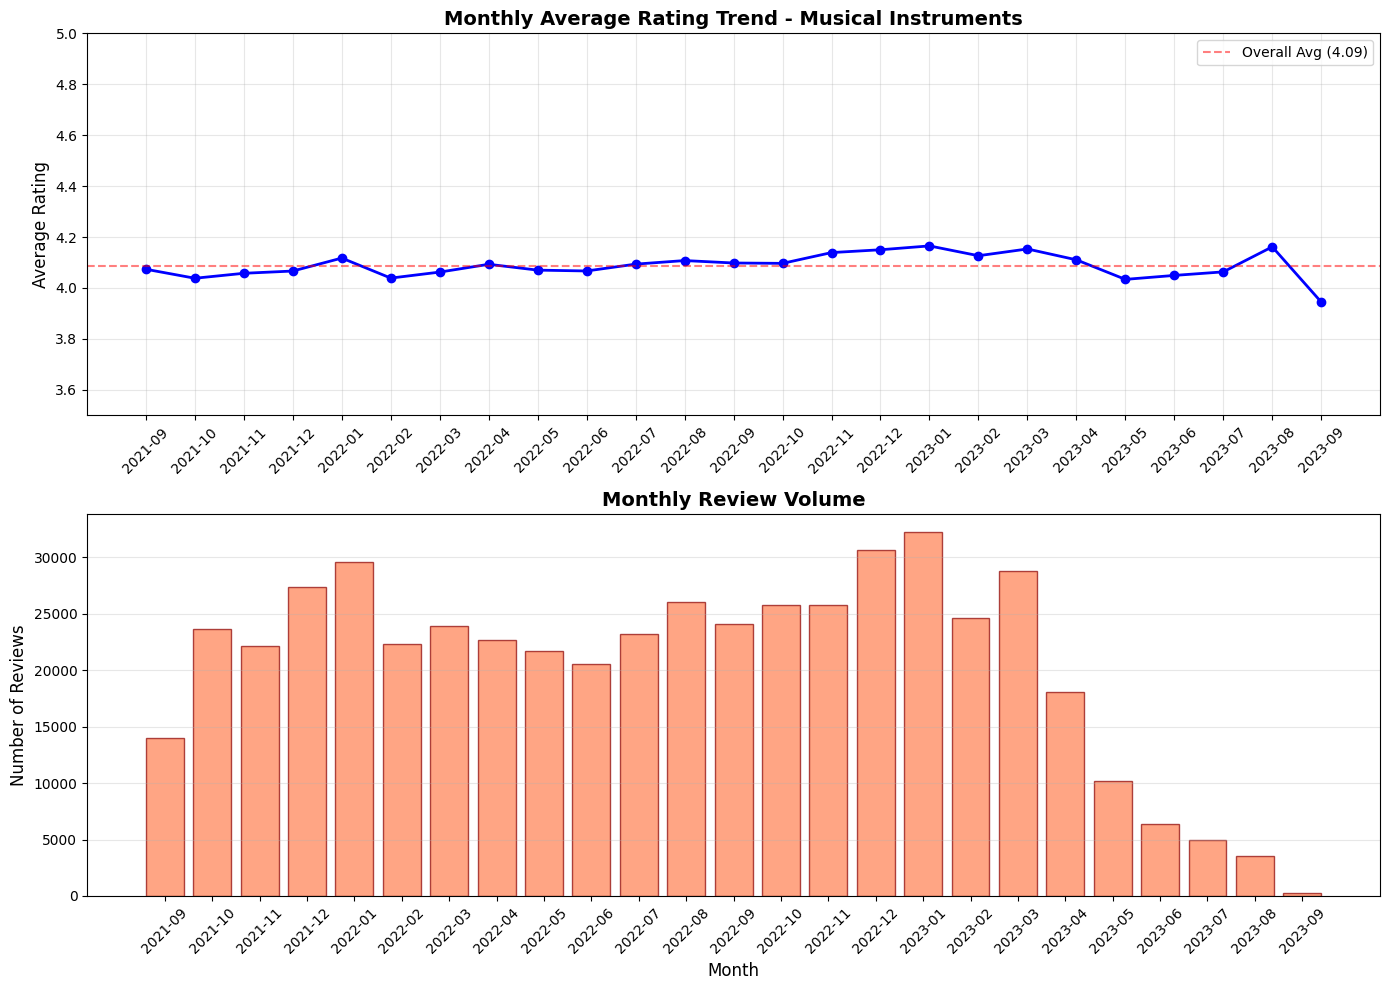

In [28]:
q6_pdf = q6_result.toPandas()
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
# Chart 1: Average rating trend
axes[0].plot(q6_pdf["year_month"], q6_pdf["avg_rating"], 
      marker='o', linewidth=2, color='blue', markersize=6)
axes[0].set_title("Monthly Average Rating Trend - Musical Instruments", 
      fontsize=14, fontweight='bold')
axes[0].set_ylabel("Average Rating", fontsize=12)
axes[0].set_ylim(3.5, 5.0)
axes[0].axhline(y=q6_pdf["avg_rating"].mean(), 
      color='red', linestyle='--', alpha=0.5, 
      label=f'Overall Avg ({q6_pdf["avg_rating"].mean():.2f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)
    
# Chart 2: Review volume
axes[1].bar(q6_pdf["year_month"], q6_pdf["review_count"], 
      color='coral', alpha=0.7, edgecolor='darkred')
axes[1].set_title("Monthly Review Volume", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Number of Reviews", fontsize=12)
axes[1].set_xlabel("Month", fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

Monthly trends in musical instrument reviews may reflect seasonal buying patterns (e.g., back-to-school, holiday gifting, New Year's resolutions for learning music).

## Q7: Running Average Rating Over Time (WINDOW FUNCTION)

In [29]:
product_reviews = reviews_df.groupBy("parent_asin") \
    .agg(count("*").alias("review_count"))

top_products = product_reviews.orderBy(col("review_count").desc()) \
    .limit(3) \
    .select("parent_asin") \
    .rdd.flatMap(lambda x: x).collect()

print(f"Top 3 products by review count: {top_products}")

Top 3 products by review count: ['B09857JRP2', 'B09W4F2X6S', 'B0C6H9T5T6']


In [30]:
print("Window function: AVG(rating) OVER (PARTITION BY product ORDER BY timestamp)\n")

window_spec_time = Window.partitionBy("parent_asin") \
    .orderBy("timestamp") \
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)

q9_result = reviews_df.filter(col("parent_asin").isin(top_products)) \
    .withColumn("running_avg", avg("rating").over(window_spec_time)) \
    .withColumn("review_date", from_unixtime(col("timestamp") / 1000)) \
    .withColumn("review_number", row_number().over(
        Window.partitionBy("parent_asin").orderBy("timestamp")
    )) \
    .join(
        metadata_df.select("parent_asin"),
        "parent_asin"
    ).select(
        "parent_asin",
        "review_number",
        "review_date",
        "rating",
        "running_avg"
    ).orderBy("parent_asin", "review_number")

print("Sample of running averages:\n")
q9_result.filter(col("review_number") % 50 == 0).show(20, truncate=50)

Window function: AVG(rating) OVER (PARTITION BY product ORDER BY timestamp)

Sample of running averages:

+-----------+-------------+-------------------+------+------------------+
|parent_asin|review_number|        review_date|rating|       running_avg|
+-----------+-------------+-------------------+------+------------------+
| B09857JRP2|           50|2014-02-03 19:44:38|   4.0|              4.34|
| B09857JRP2|          100|2014-08-23 00:06:33|   5.0|               4.6|
| B09857JRP2|          150|2015-01-13 04:44:55|   5.0| 4.593333333333334|
| B09857JRP2|          200|2015-03-11 17:54:55|   5.0|              4.65|
| B09857JRP2|          250|2015-06-25 18:08:13|   5.0|             4.712|
| B09857JRP2|          300|2015-08-13 09:30:16|   4.0| 4.703333333333333|
| B09857JRP2|          350|2015-10-09 23:39:33|   5.0| 4.677142857142857|
| B09857JRP2|          400|2015-11-10 17:34:36|   5.0|              4.68|
| B09857JRP2|          450|2015-12-29 06:35:29|   5.0| 4.688888888888889|
| B098

In [31]:
metadata_alias = metadata_df.select(
    col("parent_asin"),
    col("title").alias("product_title") 
)

q9_result = reviews_df.filter(col("parent_asin").isin(top_products)) \
    .withColumn("running_avg", avg("rating").over(window_spec_time)) \
    .withColumn("review_date", from_unixtime(col("timestamp") / 1000)) \
    .withColumn("review_number", row_number().over(
        Window.partitionBy("parent_asin").orderBy("timestamp")
    )) \
    .join(
        metadata_alias,
        "parent_asin",
        "left"
    ).select(
        "parent_asin",
        "product_title",  
        "review_number",
        "review_date",
        "rating",
        "running_avg"
    ).orderBy("parent_asin", "review_number")

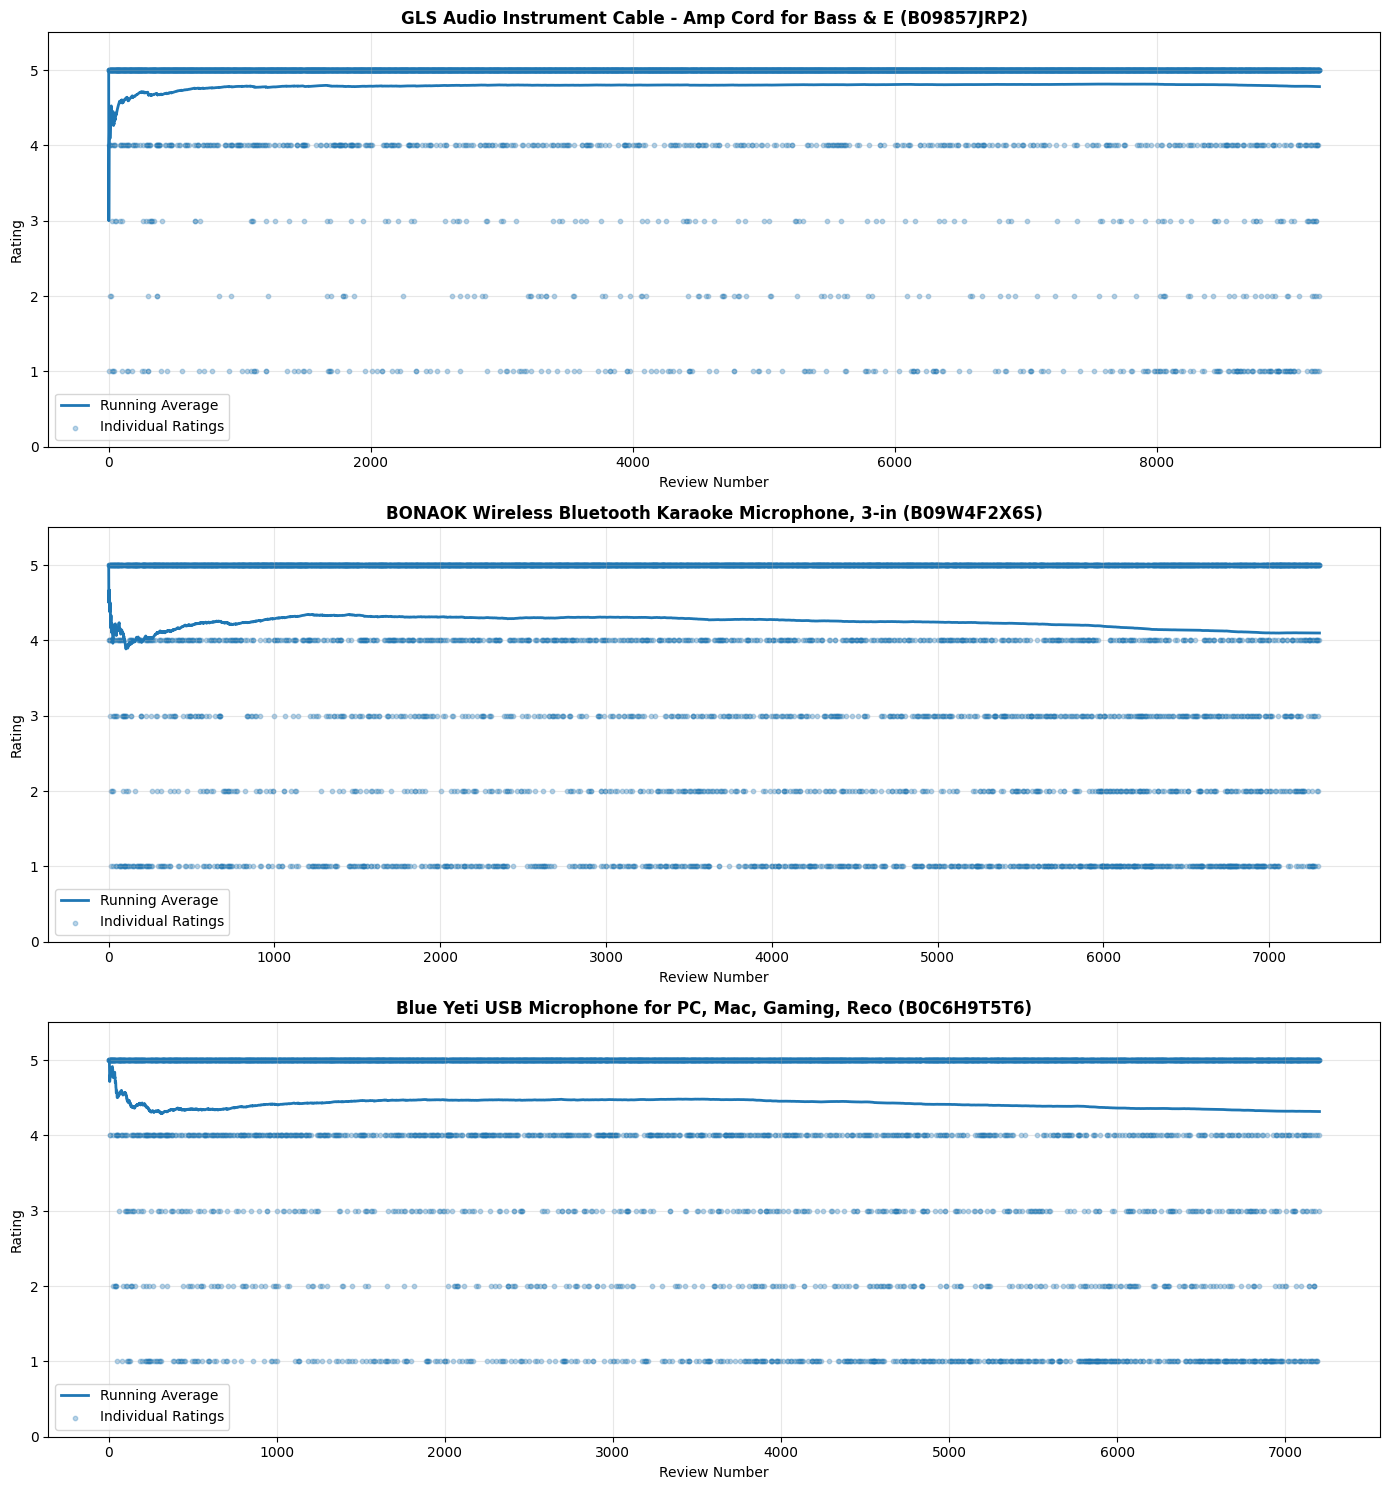

In [32]:
q9_pdf = q9_result.toPandas()

fig, axes = plt.subplots(len(top_products), 1, figsize=(14, 5*len(top_products)))
if len(top_products) == 1:
    axes = [axes]

for idx, product_id in enumerate(top_products):
    product_data = q9_pdf[q9_pdf["parent_asin"] == product_id]
    product_title = product_data["product_title"].iloc[0][:50]  # first 50 characters
    
    axes[idx].plot(product_data["review_number"], product_data["running_avg"], 
                   linewidth=2, label='Running Average')
    axes[idx].scatter(product_data["review_number"], product_data["rating"], 
                      alpha=0.3, s=10, label='Individual Ratings')
    axes[idx].set_title(f"{product_title} ({product_id})", fontweight='bold')
    axes[idx].set_xlabel("Review Number")
    axes[idx].set_ylabel("Rating")
    axes[idx].set_ylim(0, 5.5)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

For musical instruments, tracking running average ratings helps identify when instruments may have had manufacturing issues or when product improvements were made.

## Q8: Top Products by Review Volume per Price Segment

In [33]:
print("Window function: RANK() OVER (PARTITION BY price_range ORDER BY review_count)\n")

product_reviews = reviews_df.groupBy("parent_asin") \
    .agg(
        count("*").alias("review_count"),
        avg("rating").alias("avg_customer_rating")
    )

metadata_with_reviews = metadata_with_ranges.join(
    product_reviews,
    "parent_asin",
    "inner"
)
window_spec = Window.partitionBy("price_range").orderBy(col("review_count").desc())

q8_result = metadata_with_reviews.withColumn(
    "rank",
    rank().over(window_spec)
).filter(col("rank") <= 5).select(
    "price_range",
    "rank",
    "title",
    "price",
    "review_count",
    col("average_rating").alias("metadata_rating"),
    "avg_customer_rating",
    "store"
).orderBy("price_range", "rank")

print("Top 5 instruments in each price segment:\n")
q8_result.show(20, truncate=50)

Window function: RANK() OVER (PARTITION BY price_range ORDER BY review_count)

Top 5 instruments in each price segment:

+------------------+----+--------------------------------------------------+------+------------+---------------+-------------------+---------------------+
|       price_range|rank|                                             title| price|review_count|metadata_rating|avg_customer_rating|                store|
+------------------+----+--------------------------------------------------+------+------------+---------------+-------------------+---------------------+
|     Budget (<$50)|   1|GLS Audio Instrument Cable - Amp Cord for Bass ...|  14.3|        9242|            4.8|  4.779593161653322|            GLS Audio|
|     Budget (<$50)|   2|BONAOK Wireless Bluetooth Karaoke Microphone, 3...| 29.99|        7303|            4.4|  4.097357250445023|               BONAOK|
|     Budget (<$50)|   3|Donner Guitar Delay Pedal, Yellow Fall Analog D...| 39.99|        6540|        

Top instruments by review volume in each price segment help identify market leaders and popular choices. For musical instruments, this reveals buyer preferences across different budget levels and instrument types.